Import files

In [65]:
import os
import numpy as np
import pandas as pd
import torch

def read_file(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            mass, intensity = line.strip().split('\t')
            data.append([float(mass), float(intensity)])
    return np.array(data)

directory = r'C:\Users\Marshall\TEST DATA\TEST DATA\DalbergiaLatifolia'
file_paths = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.txt')]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

all_data = []
for file_path in file_paths:
    data = pd.read_csv(file_path,sep= '\t',header = 1)
    all_data.append(data)




Scale the data

In [66]:
all_data_scaled = []
for seq in all_data:
    seq = np.array(seq)
    mass_values = seq[:, 0]
    intensity_values = seq[:, 1]

    # Calculate the minimum and maximum intensity values for this sequence
    intensity_min = np.min(intensity_values)
    intensity_max = np.max(intensity_values)

    # Scale the intensity values using the max-min scaler
    scaled_intensity = (intensity_values - intensity_min) / (intensity_max - intensity_min)

    # Combine the scaled intensity values with the mass values
    scaled_seq = np.column_stack((mass_values, scaled_intensity))

    all_data_scaled.append(scaled_seq)

In [67]:
from torch.nn.utils.rnn import pad_sequence

#all_data_scaled = np.concatenate(all_data_scaled, axis=0)

max_seq_len = max(len(seq) for seq in all_data)

# Create a list of tensors from the concatenated data
tensor_data = [torch.tensor(seq, dtype=torch.float32) for seq in all_data_scaled]

# Pad the sequences
padded_data = pad_sequence(tensor_data, batch_first=True, padding_value=0.0)


In [68]:
features = padded_data[:, :, 0].unsqueeze(-1)  # Mass values
targets = padded_data[:, :, 1].unsqueeze(-1)   # Intensity values

In [69]:
# Create a mask tensor for the features
features_mask = torch.ones_like(features, dtype=torch.bool)
for i, seq in enumerate(tensor_data):
    features_mask[i, len(seq):, 0] = False

# Create a mask tensor for the targets
targets_mask = torch.ones_like(targets, dtype=torch.bool)
for i, seq in enumerate(tensor_data):
    targets_mask[i, len(seq):, 0] = False


VAE setup

In [71]:
import torch
import torch.nn as nn

class RecurrentVAE(nn.Module):
    def __init__(self, feature_dim, target_dim, latent_dim, hidden_dim, num_layers):
        super(RecurrentVAE, self).__init__()
        self.feature_dim = feature_dim
        self.target_dim = target_dim
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Encoder
        self.encoder_rnn = nn.LSTM(feature_dim, hidden_dim, num_layers, batch_first=True)
        self.mu = nn.Linear(hidden_dim, latent_dim)
        self.log_var = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.decoder_rnn = nn.LSTM(latent_dim, hidden_dim, num_layers, batch_first=True)
        self.decoder_out = nn.Linear(hidden_dim, target_dim)

    def encode(self, features, mask=None):
        encoder_outputs, _ = self.encoder_rnn(features)
        if mask is not None:
            encoder_outputs = encoder_outputs * mask.unsqueeze(-1)
        _, (h_n, _) = self.encoder_rnn(encoder_outputs)
        h_n = h_n.view(self.num_layers, -1, self.hidden_dim)[-1]
        mu = self.mu(h_n)
        log_var = self.log_var(h_n)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def decode(self, z, features, mask=None):
        z = z.repeat(1, features.size(1), 1)
        outputs, _ = self.decoder_rnn(z, (self.get_hidden_state(features, mask), None))
        recon_targets = self.decoder_out(outputs)
        if mask is not None:
            recon_targets = recon_targets * mask.unsqueeze(-1)
        return recon_targets

    def get_hidden_state(self, features, mask=None):
        encoder_outputs, _ = self.encoder_rnn(features)
        if mask is not None:
            encoder_outputs = encoder_outputs * mask.unsqueeze(-1)
        _, (h_n, _) = self.encoder_rnn(encoder_outputs)
        return h_n

    def forward(self, features, targets, mask=None):
        if mask is not None:
            features_mask, targets_mask = mask
        else:
            features_mask, targets_mask = None, None

        mu, log_var = self.encode(features, mask=features_mask)
        z = self.reparameterize(mu, log_var)
        targets_recon = self.decode(z, features, mask=targets_mask)
        return targets_recon, mu, log_var

Training the VAE

In [75]:
import torch
import torch.nn.functional as F

# Instantiate the model
vae = RecurrentVAE(feature_dim=1, target_dim=1, latent_dim=32, hidden_dim=64, num_layers=2)

# Move the model to GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = vae.to(device)

# Move the data to GPU (if available)
features = features.to(device)
targets = targets.to(device)
features_mask = features_mask.to(device)
targets_mask = targets_mask.to(device)

# Define the optimizer and loss function
optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)
reconstruction_loss = F.mse_loss

# Training loop
num_epochs = 100
batch_size = 11

for epoch in range(num_epochs):
    vae.train()
    total_loss = 0
    num_batches = 0

    for i in range(0, len(features), batch_size):
        batch_features = features[i:i+batch_size]
        batch_targets = targets[i:i+batch_size]
        batch_features_mask = features_mask[i:i+batch_size]
        batch_targets_mask = targets_mask[i:i+batch_size]

        optimizer.zero_grad()

        targets_recon, mu, log_var = vae(batch_features, batch_targets,
                                         mask=(batch_features_mask, batch_targets_mask))

        # Compute the reconstruction loss
        recon_loss = reconstruction_loss(targets_recon * batch_targets_mask.unsqueeze(-1),
                                         batch_targets * batch_targets_mask.unsqueeze(-1),
                                         reduction='sum')

        # Compute the KL divergence loss
        kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        loss = recon_loss + kl_div

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

    avg_loss = total_loss / num_batches
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

RuntimeError: The size of tensor a (11) must match the size of tensor b (1408) at non-singleton dimension 1

Create output

In [29]:
# Generate synthetic data
latent_samples = torch.randn(1000, latent_dim).to(device)
synthetic_data = vae.decode(latent_samples)

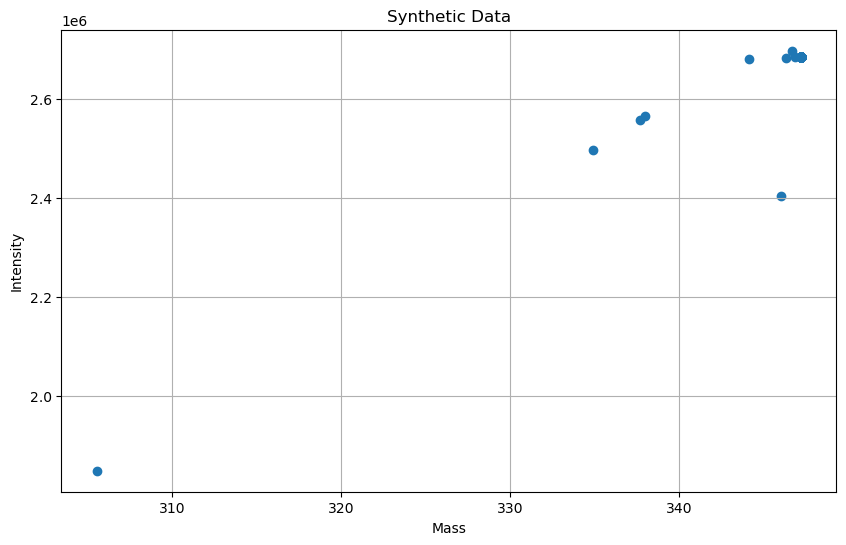

In [30]:
# Denormalize the synthetic data
synthetic_data = synthetic_data.cpu().detach().numpy()
denormalized_samples = (synthetic_data * stds) + means

# Save the synthetic data
np.savetxt('synthetic_data.txt', denormalized_samples, delimiter='\t')

# Visualize the synthetic data
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(denormalized_samples[:, 0], denormalized_samples[:, 1])
plt.xlabel('Mass')
plt.ylabel('Intensity')
plt.title('Synthetic Data')
plt.grid(True)
plt.show()

# Save the model
torch.save(vae.state_dict(), 'vae_model.pth')


